In [1]:
#from shapely.geometry import Point
from functools import reduce
from faker import Faker
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd
import datetime
import random
import pprint
import bcrypt
import click
import time
import json
import pytz
%matplotlib inline

pp = pprint.PrettyPrinter(indent=2)

In [2]:
def sort_subreddits(filename, sort_with):
    profile_pics = {}
    with open(filename, 'r') as subreddit_file:
        subs = json.load(subreddit_file)
        for k,v in sort_with.items():
            profile_pics[k] = reduce(lambda x,y: list(set(x + subs[y])), v, [])
    return profile_pics

def sexual_orientation():
    orientation = [
        'heterosexual',
        'homosexual',
        'bisexual']
    return np.random.choice(orientation, p=[0.6, 0.2, 0.2])


In [3]:
def profile_pic_generator():
    subreddit_genders = {
        'male': ['ladyboners', 'hotguys'],
        'female': ['prettygirls', 'beautifulfemales']
    }
    profile_pics = sort_subreddits('./ladyboners_hotguys_prettygirls_beautifulfemales.json', subreddit_genders)
    length = {'male': len(profile_pics['male']),
              'female': len(profile_pics['female'])}
    counter = {'male': 0,
               'female': 0}
    def next_profile_pic(gender):
        if gender not in ['male', 'female']:
            return ''
        picture_url = profile_pics[gender][counter[gender] % length[gender]]
        counter[gender] += 1
        return picture_url
    return next_profile_pic

In [4]:
def generate_age_distribution(min_age = 18, max_age = 77, size = 1000):
    ages = 13 + 12 * np.random.lognormal(0, 0.42, size = size)
    return np.clip(ages, min_age, max_age)

def plot_distribution(dist):
    print("min:", min(dist))
    print("max:", max(dist))
    num_bins = 2 * int(max(dist) - min(dist))
    plt.hist(dist, bins = num_bins if num_bins < 420 else 420)
    plt.show()

min: 18.0
max: 50.37641026383524


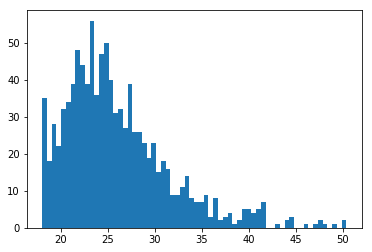

In [5]:
ages = generate_age_distribution()
plot_distribution(ages)

In [6]:
def generate_date_of_birth(min_age = 18, max_age = 77, size = 1000):
    tz = pytz.timezone('Europe/Paris')
    ages = generate_age_distribution(min_age, max_age, size)
    now = datetime.datetime.now(tz)
    dob = [(now - datetime.timedelta(days = int(366 * age))).strftime(format="%Y-%m-%d %H:%M:%S%z") for age in ages]
    return dob

In [7]:
dob = generate_date_of_birth(size=10)
print(dob)

['2000-09-07 04:58:22+0200', '1999-12-23 04:58:22+0200', '1991-12-15 04:58:22+0200', '1991-06-29 04:58:22+0200', '1996-06-28 04:58:22+0200', '1998-06-15 04:58:22+0200', '1997-12-31 04:58:22+0200', '1996-08-30 04:58:22+0200', '1994-07-10 04:58:22+0200', '1990-11-15 04:58:22+0200']


min: 3.4642988577979184
max: 2957.803465850396


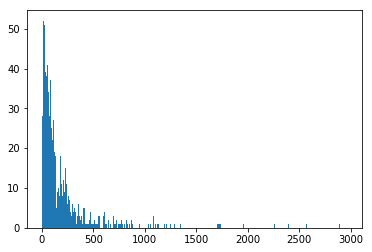

In [8]:
def generate_minutes_distribution(size = 1000):
    minutes = 100 * np.random.lognormal(0, 1.2, size = size)
    return minutes

plot_distribution(generate_minutes_distribution())

In [9]:
def generate_last_seen(size = 1000):
    tz = pytz.timezone('Europe/Paris')
    minutes = generate_minutes_distribution(size = size)
    now = datetime.datetime.now(tz)
    last_seen = [(now - datetime.timedelta(seconds = int(60 * minute))).strftime(format="%Y-%m-%d %H:%M:%S%z") for minute in minutes]
    return last_seen

In [28]:
def generate_fake_profiles(size = 1000):
    start = time.time()
    fake = Faker('fr_FR')
    next_profile_pic = profile_pic_generator()
    hashed_password = bcrypt.hashpw("auie", bcrypt.gensalt(10))
    profiles = []
    
    for _ in tqdm(range(size)):
        profile = fake.profile()
        profile['hashed_password'] = hashed_password
        name = profile['name'].split(' ')
        profile['firstname'] = name[0]
        profile['lastname'] = ' '.join(name[1:])
        profile['gender'] = 'male' if profile['sex'] == 'M' else 'female'
        profile['sexual_orientation'] = sexual_orientation()
        profile['bio'] = fake.text(max_nb_chars = 200)
        profile['num_pics'] = 1
        profile['url_pp'] = next_profile_pic(profile['gender'])
        profile['email'] = profile['mail']
        lon, lat = fake.local_latlng(country_code="FR", coords_only=True)
        profile['position'] =  '(' + lat + ',' + lon + ')'
        profile['popularity_score'] = random.randrange(100)
        profile['verified'] = True
        profile.pop('mail')
        profile.pop('birthdate')
        profile.pop('blood_group')
        profile.pop('address')
        profile.pop('company')
        profile.pop('job')
        profile.pop('name')
        profile.pop('residence')
        profile.pop('sex')
        profile.pop('ssn')
        profile.pop('website')
        profile.pop('current_location')
        profiles.append(profile)
        
    df = pd.DataFrame(profiles)
    df['date_of_birth'] = generate_date_of_birth(min_age = 18, max_age = 77, size = size)
    df['last_seen'] = generate_last_seen(size = size)
    original_length = len(df)
    df = df.drop_duplicates('username')
    df = df.drop_duplicates('email')
    num_duplicated = original_length - len(df)
    if (num_duplicated):
        print("dropped {} row(s) (duplicated email or username)".format(num_duplicated))
    return df


In [29]:
df = generate_fake_profiles(size = 1000)

100%|██████████| 1000/1000 [00:04<00:00, 205.18it/s]

dropped 10 row(s) (duplicated email or username)


In [30]:
df.head()

,bio,email,firstname,gender,hashed_password,lastname,num_pics,popularity_score,position,sexual_orientation,url_pp,username,verified,date_of_birth,last_seen
0,Travers long arrêter trésor.\nPont ennemi mais...,besnardraymond@tiscali.fr,Denis,male,$2a$10$bPpp92tEaeb7a47YbXKwJueHBDOeLQOLZNRNe/Q...,Michaud,1,60,"(4.7934,45.69558)",homosexual,https://66.media.tumblr.com/15fe3cfc35c276b302...,gabrielle46,True,1992-09-07 05:17:38+0200,2019-05-09 02:43:45+0200
1,Personne gens lui ministre. Produire mort musi...,marthe66@sfr.fr,Martin,male,$2a$10$bPpp92tEaeb7a47YbXKwJueHBDOeLQOLZNRNe/Q...,Chauvet,1,28,"(1.33467,43.61058)",heterosexual,http://i.imgur.com/jgjcv.jpg,alainrodrigues,True,1996-12-09 05:17:38+0200,2019-05-09 04:00:52+0200
2,Facile miser lever. Enfin perdre machine siège...,agodard@noos.fr,Margot,female,$2a$10$bPpp92tEaeb7a47YbXKwJueHBDOeLQOLZNRNe/Q...,Pereira,1,94,"(2.2469,48.90472)",bisexual,http://i.imgur.com/eBzb69S.jpg,henriette17,True,1993-01-16 05:17:38+0200,2019-05-09 03:15:02+0200
3,Construire verser indiquer attitude sommet pai...,lucasmargaret@dbmail.com,Paul,male,$2a$10$bPpp92tEaeb7a47YbXKwJueHBDOeLQOLZNRNe/Q...,Launay,1,40,"(5.4384,43.2907)",heterosexual,http://i.imgur.com/J8B8f.jpg,zacharie97,True,1997-05-19 05:17:38+0200,2019-05-09 03:03:02+0200
4,Monde minute cela marche. Finir pendre parole ...,diane97@yahoo.fr,David-Bernard,male,$2a$10$bPpp92tEaeb7a47YbXKwJueHBDOeLQOLZNRNe/Q...,Chauvin,1,20,"(4.7934,45.69558)",homosexual,http://25.media.tumblr.com/tumblr_mc3c1x4kXV1r...,xpascal,True,1990-10-15 05:17:38+0200,2019-05-09 03:49:10+0200


In [31]:
df.to_csv("../db/fake_profiles.csv", sep = ';', index_label = 'id')